In [ ]:
import os
import math
from datetime import datetime, timedelta
import importlib


import ee
import geemap
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import shape
from tqdm import tqdm

# Local module
import data_collection
importlib.reload(data_collection)

from data_collection import (
    mask_no_labeled_pixel_all_zones,
    rasterize_labels_per_zone,
    count_total_nan_in_tifs,
    get_median_image,
    create_gee_geometries
)


: 

In [3]:
gdf = gpd.read_file("/Users/placiermoise/Documents/dsw_proj/Parcelles/RPG_2023/PARCELLES_GRAPHIQUES.gpkg")

In [1]:
print(gdf[LABEL].unique())

NameError: name 'gdf' is not defined

In [ ]:
# Load the shapefile containing the parcels
#gdf = gpd.read_file("/Users/placiermoise/Documents/dsw_proj/Parcelles/RPG_2023/PARCELLES_GRAPHIQUES.gpkg")
#gdf  = gdf.to_crs(epsg=4326)
#Label_culture = pd.read_csv("../data/REF_CULTURES_GROUPES.csv", sep=";")
#Label_culture["Label"] = pd.to_numeric(Label_culture["Label"], errors="coerce").astype("Int64")
#Label_culture["Label"] = Label_culture["Label"].fillna(0).astype(int)
#gdf = gdf.merge(Label_culture[["Label","CODE_CULTURE"]], how="left", left_on="CODE_CULTU", right_on="CODE_CULTURE") #TODO check if this is right (CODE_CULTU)
#gdf = gdf.rename(columns={"Label": "LABEL"})
#Converting the ID_PARCEL column to numeric and if it fails, it will be set to NaN, then fill NaN with 0 and convert to int
gdf["ID_PARCEL"] = pd.to_numeric(gdf["ID_PARCEL"], errors="coerce").astype("Int64")
gdf["ID_PARCEL"] = gdf["ID_PARCEL"].fillna(0).astype(int)
#Remove duplicated columns
gdf = gdf.loc[:, ~gdf.columns.duplicated()]
# Save the updated GeoDataFrame to a new file
gdf.to_file("/Users/placiermoise/Documents/dsw_proj/Parcelles/RPG_2023/PARCELLES_GRAPHIQUES.gpkg", driver="GPKG")#TODO no , it will work only for Moise PC


: 

In [ ]:
#Accessing Earth Engine
#TODO check if it works and also if it is necesary every run and if it should substitued with something else
ee.Authenticate(scopes=['https://www.googleapis.com/auth/earthengine',
                        'https://www.googleapis.com/auth/drive'])
ee.Initialize() 

In [ ]:
# Create a geemap Map instance (interctive map)
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
#TODO ask moise if the comments are correct!
#Draw your area of interest on the map manually using the jupyter interface.
# After drawing, you can access the drawn features.

coordinates = []
# Iterate through the drawn features and extract their coordinates
for feature in Map.draw_features: #TODO ask moise what is Map.draw_features and where it comes from
        coordinate = feature.geometry().getInfo()
        coordinates.append(coordinate['coordinates'])
coordinates  

: 

[[0.472412, 44.504341],
 [0.692139, 46.149394],
 [5.218506, 45.413876],
 [1.450195, 48.166085]]

In [ ]:
coords_list = coordinates #TODO why ?

List_Geometry_data_collect = create_gee_geometries(coords_list, side_km=10)

i=0
for geometry in List_Geometry_data_collect :
    i+=1
    Map.addLayer(geometry, {}, f"zone{i}")

Map


Map(bottom=6043.0, center=[47.29413372501023, 6.8115234375], controls=(WidgetControl(options=['position', 'tra…

In [90]:
start_date = '2023-01-01'
end_date = '2023-12-31'

#ranges = generate_half_month_ranges(start_date, end_date)
ranges = generate_monthly_ranges(start_date, end_date)
ranges

[('2023-01-01', '2023-02-01'),
 ('2023-02-01', '2023-03-01'),
 ('2023-03-01', '2023-04-01'),
 ('2023-04-01', '2023-05-01'),
 ('2023-05-01', '2023-06-01'),
 ('2023-06-01', '2023-07-01'),
 ('2023-07-01', '2023-08-01'),
 ('2023-08-01', '2023-09-01'),
 ('2023-09-01', '2023-10-01'),
 ('2023-10-01', '2023-11-01'),
 ('2023-11-01', '2023-12-01'),
 ('2023-12-01', '2023-12-31')]

In [ ]:
zone_number = 0

for geometry in List_Geometry_data_collect : 

    zone_number += 1

    # Create a list of median images for each date range
    median_images = [get_median_image(start, end, geometry) for start, end in ranges]

    # Create a collection from the images
    image_collection = ee.ImageCollection(median_images)

    folderName = f'GEE_export_zone{zone_number}'

    # export to TIFF format
    export_folder = str(folderName)
    export_maxPixels = 1e10
    
    export_tiff(image_collection,geometry,export_folder,export_maxPixels )

###############################################################################################
######### moove Zone folder of tif  from drive to ../data/tif     !!!!!!!!!!!! ################
###############################################################################################

Export started for image 1/13, date : 20230101
Export started for image 2/13, date : 20230131
Export started for image 3/13, date : 20230302
Export started for image 4/13, date : 20230401
Export started for image 5/13, date : 20230501
Export started for image 6/13, date : 20230531
Export started for image 7/13, date : 20230630
Export started for image 8/13, date : 20230730
Export started for image 9/13, date : 20230829
Export started for image 10/13, date : 20230928
Export started for image 11/13, date : 20231028
Export started for image 12/13, date : 20231127
Export started for image 13/13, date : 20231227
Export started for image 1/13, date : 20230101
Export started for image 2/13, date : 20230131
Export started for image 3/13, date : 20230302
Export started for image 4/13, date : 20230401
Export started for image 5/13, date : 20230501
Export started for image 6/13, date : 20230531
Export started for image 7/13, date : 20230630
Export started for image 8/13, date : 20230730
Export st

In [25]:
rasterize_labels_per_zone(base_dir="../data/Tif", gdf=gdf, label_column="LABEL")

🔄  processing zone n°: zone6
✅ ground trouth label saved : ../data/Tif/zone6/labels_raster.tif
🔄  processing zone n°: zone1
✅ ground trouth label saved : ../data/Tif/zone1/labels_raster.tif
🔄  processing zone n°: zone7
✅ ground trouth label saved : ../data/Tif/zone7/labels_raster.tif
🔄  processing zone n°: zone2
✅ ground trouth label saved : ../data/Tif/zone2/labels_raster.tif
🔄  processing zone n°: zone5
✅ ground trouth label saved : ../data/Tif/zone5/labels_raster.tif
🔄  processing zone n°: zone4
✅ ground trouth label saved : ../data/Tif/zone4/labels_raster.tif
🔄  processing zone n°: zone3
✅ ground trouth label saved : ../data/Tif/zone3/labels_raster.tif


In [8]:

base_dir = "../data/Tif"
mask_no_labeled_pixel_all_zones(base_dir)
count_total_nan_in_tifs()


⚠️ Label raster not found in ../data/Tif/zone6, skipping.
⚠️ Label raster not found in ../data/Tif/zone1, skipping.
⚠️ Label raster not found in ../data/Tif/zone7, skipping.
⚠️ Label raster not found in ../data/Tif/zone2, skipping.
⚠️ Label raster not found in ../data/Tif/zone5, skipping.
⚠️ Label raster not found in ../data/Tif/zone4, skipping.
⚠️ Label raster not found in ../data/Tif/zone3, skipping.
Traitement de la zone : zone1
  Nombre total de NaN dans zone1: 25694
Traitement de la zone : zone2
  Nombre total de NaN dans zone2: 106541
Traitement de la zone : zone3
  Nombre total de NaN dans zone3: 810816
Traitement de la zone : zone4
  Nombre total de NaN dans zone4: 315364
Traitement de la zone : zone5
  Nombre total de NaN dans zone5: 5917
Traitement de la zone : zone6
  Nombre total de NaN dans zone6: 658462
Traitement de la zone : zone7
  Nombre total de NaN dans zone7: 228676
Nombre total de NaN dans toutes les zones : 2151470


np.int64(2151470)

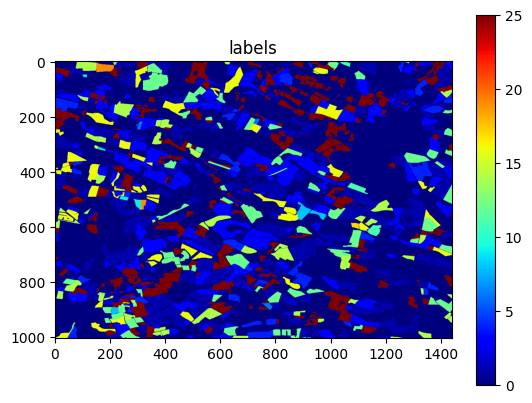

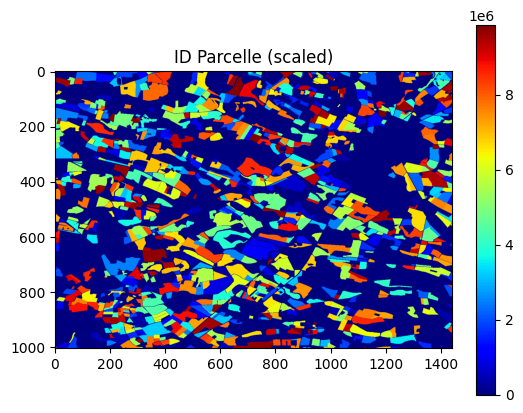

In [11]:
import rasterio
import matplotlib.pyplot as plt

# Open the TIFF file
with rasterio.open("/Users/placiermoise/Documents/dsw_proj/remote sensing crop classification/data/Tif/zone6/labels_raster_masked.tif") as src:
    labels = src.read(1) 
    Id_Parcelle = src.read(2) 

plt.imshow(labels, cmap='jet')  # or 'viridis', 'jet', etc.
plt.colorbar()
plt.title('labels')
plt.show()
plt.imshow(Id_Parcelle, cmap='jet', vmin=np.min(Id_Parcelle), vmax=np.max(Id_Parcelle))
plt.colorbar()
plt.title('ID Parcelle (scaled)')
plt.show()